In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [83]:
def gen_psdm(n):
    # multiplies a matrix by its transpose to get a positve semidefinite matrix
    
    if n <= 0 or not float(n).is_integer():
        raise ValueError('Invalid n')
    
    else:
        mat = np.random.random((n, n))
        psdm = np.matmul(mat, np.transpose(mat))
        return psdm / np.max(psdm)

In [84]:
def set_opposite_diag(mat):
    # changes elements of the opposite diagonal
    
    mat = np.fliplr(mat)
    
    for i in range(0,np.shape(mat)[0]):
        mat[i,i] = -mat[i,i]
        
    return np.fliplr(mat)

# Create Technologies

In [85]:
Xi = np.matrix([[3, 6], [5, 4]])
print(Xi)

[[3 6]
 [5 4]]


In [86]:
# number of technologies
n = 2

# define cov matrices
Sigma_t = gen_psdm(n)
Sigma_s = gen_psdm(n)

# set cov to negative
Sigma_t = set_opposite_diag(Sigma_t)
Sigma_s = set_opposite_diag(Sigma_s)

In [87]:
corr_coeff = lambda mat: mat[0,1]/ np.sqrt(mat[0,0]*mat[1,1])
print('Sigma t correlation: {0:0.3f}'.format(corr_coeff(Sigma_t)))
print('Sigma s correlation: {0:0.3f}'.format(corr_coeff(Sigma_s)))

Sigma t correlation: -0.980
Sigma s correlation: -0.978


In [88]:
Sigma_t

array([[ 1.        , -0.4752441 ],
       [-0.4752441 ,  0.23504327]])

# Mean Variance Analysis

In [89]:
def array_to_list(arr):
    return np.array(arr).ravel().tolist()

## Generate random combinations of technologies

In [90]:
results = []
samples = 200
w_1_range = np.linspace(0, 1, samples)

for i in range(0,samples):
    
    # random weights
    w = np.array([w_1_range[i], 1 - w_1_range[i]])

    # stats
    mu = np.matmul(Xi, w)
    sigma_t = np.matmul(np.matmul(w.T, Sigma_t), w)
    sigma_s = np.matmul(np.matmul(w.T, Sigma_s), w)
    
    # update results
    results.append(array_to_list(w) + array_to_list(mu) + array_to_list(sigma_t) + array_to_list(sigma_s))

In [91]:
results_df = pd.DataFrame(results, columns = ['w_1', 'w_2', 'mu_t', 'mu_s', 'sigma_t_2', 'sigma_s_2'])

In [92]:
# both period variance and output will be just the sum of their variances and means since these are normal rv's
results_df['mu_both'] = np.add(results_df['mu_t'], results_df['mu_s'])
results_df['sigma_both_2'] = np.add(results_df['sigma_t_2'], results_df['sigma_s_2'])

## Plot Results

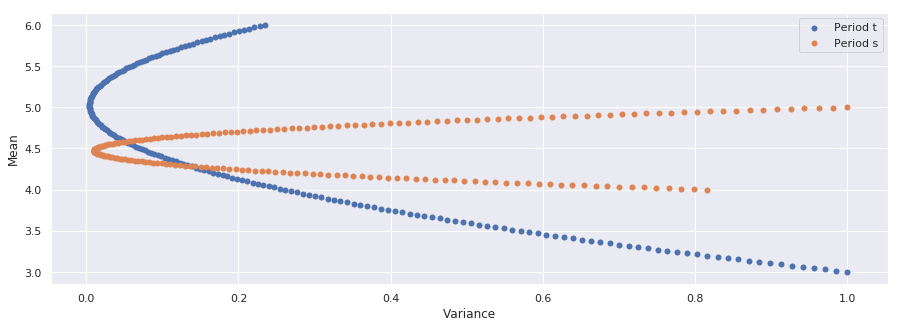

In [93]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.scatterplot(data = results_df, x = 'sigma_t_2', y = 'mu_t', linewidth=0, ax = ax1, label = 'Period t')
sns.scatterplot(data = results_df, x = 'sigma_s_2', y = 'mu_s', linewidth=0, ax = ax1, label = 'Period s')
ax1.set_xlabel("Variance")
ax1.set_ylabel("Mean");

# Cobb-Douglas Utility Example

In [206]:
# CD Utility params
alpha_t = 0.3
alpha_s = 1 - alpha_t

## Find Utility at each point

In [207]:
U    = lambda y_t,y_s: (y_t**alpha_t)*(y_s**alpha_s) 
U_tt = lambda y_t,y_s: (alpha_t)*(alpha_t - 1)*(y_t**(alpha_t-2))*(y_s**alpha_s)
U_ss = lambda y_t,y_s: (alpha_s)*(alpha_s - 1)*(y_s**(alpha_s-2))*(y_t**alpha_t)

In [208]:
# Mean component of utility
results_df['Utility_mc'] = results_df.apply(lambda x: U(x.mu_t, x.mu_s), axis = 1)

In [209]:
# Variance component of utility
results_df['Utility_vc'] = 0.5*results_df.apply(lambda x: U_tt(x.mu_t, x.mu_s)*(x.sigma_t_2)
                                               + U_ss(x.mu_t, x.mu_s)*(x.sigma_s_2), axis = 1)

In [210]:
# Total Utility
results_df['Utility'] = np.add(results_df['Utility_mc'], results_df['Utility_vc'])

## Stats at Max Utility

In [211]:
max_util_idx = results_df['Utility'].idxmax()
pd.DataFrame(results_df.iloc[max_util_idx, :])

,54
w_1,0.271357
w_2,0.728643
mu_t,5.185930
mu_s,4.271357
sigma_t_2,0.010491
sigma_s_2,0.157431
mu_both,9.457286
sigma_both_2,0.167923
Utility_mc,4.527350
Utility_vc,-0.004287


## Plot Results

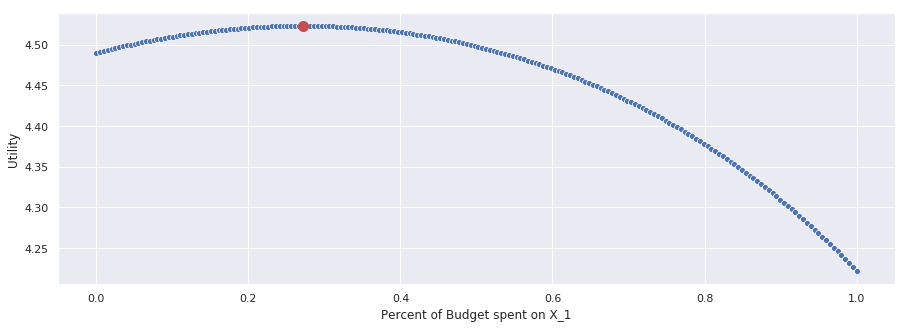

In [204]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.scatterplot(data = results_df, x = 'w_1', y = 'Utility')
plt.plot(results_df['w_1'].iloc[max_util_idx], results_df['Utility'].iloc[max_util_idx], 'ro', markersize = 10)
ax1.set_xlabel("Percent of Budget spent on X_1")
ax1.set_ylabel("Utility");

## MV Plots at Max Utility

The red point indicates the location the optimal frontier that maximizes both period utility. This point doesn't actually min varaince on either frontier. 

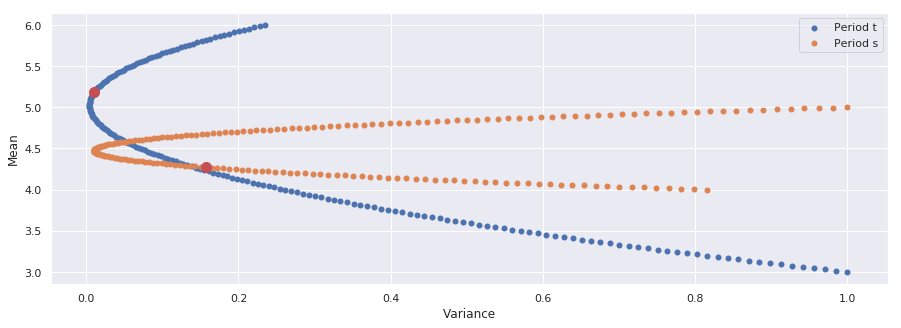

In [205]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.scatterplot(data = results_df, x = 'sigma_t_2', y = 'mu_t', linewidth=0, ax = ax1, label = 'Period t')
sns.scatterplot(data = results_df, x = 'sigma_s_2', y = 'mu_s', linewidth=0, ax = ax1, label = 'Period s')
plt.plot(results_df['sigma_t_2'].iloc[max_util_idx], results_df['mu_t'].iloc[max_util_idx], 'ro', markersize = 10)
plt.plot(results_df['sigma_s_2'].iloc[max_util_idx], results_df['mu_s'].iloc[max_util_idx], 'ro', markersize = 10)
ax1.set_xlabel("Variance")
ax1.set_ylabel("Mean");

Both period output is the total electricity output and its variance

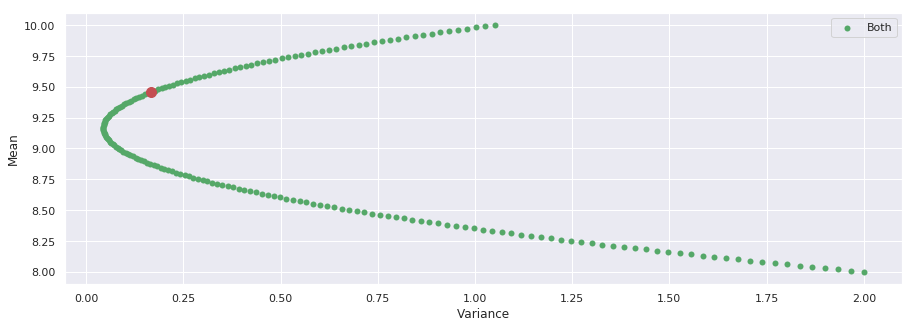

In [166]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.scatterplot(data = results_df, x = 'sigma_both_2', y = 'mu_both', color = 'g', linewidth=0, ax = ax1, label = 'Both')
plt.plot(results_df['sigma_both_2'].iloc[max_util_idx], results_df['mu_both'].iloc[max_util_idx], 'ro', markersize = 10)
ax1.set_xlabel("Variance")
ax1.set_ylabel("Mean");

In [172]:
results_df.head()

,w_1,w_2,mu_t,mu_s,sigma_t_2,sigma_s_2,mu_both,sigma_both_2,Utility_mc,Utility_vc,Utility,mu_comp,sigma_2_comp
0,0.000000,1.000000,6.000000,4.000000,0.235043,0.815983,10.000000,1.051026,4.517388,-0.027287,4.490101,4.600000,0.641701
1,0.005025,0.994975,5.984925,4.005025,0.227960,0.798992,9.989950,1.026952,4.517949,-0.026649,4.491300,4.598995,0.627682
2,0.010050,0.989950,5.969849,4.010050,0.220987,0.782182,9.979899,1.003169,4.518496,-0.026020,4.492476,4.597990,0.613823
3,0.015075,0.984925,5.954774,4.015075,0.214124,0.765553,9.969849,0.979677,4.519029,-0.025398,4.493631,4.596985,0.600124
4,0.020101,0.979899,5.939698,4.020101,0.207372,0.749105,9.959799,0.956477,4.519550,-0.024786,4.494764,4.595980,0.586585


# Epstein-Zin Preferences

In [199]:
# CD Utility params
beta = 0.95
rho = -1
gamma = 2

## Find Utility at each point

In [200]:
results_df['u_1'] = (1-beta)*(results_df['mu_t']**(1-rho))
results_df['u_2'] = beta*((
    ((1-beta)**(1-gamma)) *
    ((1-rho)*(1-gamma)*results_df['mu_s']))**((1-rho)/(1-gamma)))

# Total Utility
results_df['Utility'] = (results_df['u_1'] + results_df['u_2'])**(1/(1-rho))

In [201]:
results_df.head()

,w_1,w_2,mu_t,mu_s,sigma_t_2,sigma_s_2,mu_both,sigma_both_2,Utility_mc,Utility_vc,Utility,mu_comp,sigma_2_comp,u_1,u_2,Utility_EZ
0,0.000000,1.000000,6.000000,4.000000,0.235043,0.815983,10.000000,1.051026,4.517388,-0.027287,1.341655,4.600000,0.641701,1.800000,0.000037,4.446807
1,0.005025,0.994975,5.984925,4.005025,0.227960,0.798992,9.989950,1.026952,4.517949,-0.026649,1.338284,4.598995,0.627682,1.790966,0.000037,4.435634
2,0.010050,0.989950,5.969849,4.010050,0.220987,0.782182,9.979899,1.003169,4.518496,-0.026020,1.334913,4.597990,0.613823,1.781955,0.000037,4.424461
3,0.015075,0.984925,5.954774,4.015075,0.214124,0.765553,9.969849,0.979677,4.519029,-0.025398,1.331542,4.596985,0.600124,1.772967,0.000037,4.413288
4,0.020101,0.979899,5.939698,4.020101,0.207372,0.749105,9.959799,0.956477,4.519550,-0.024786,1.328171,4.595980,0.586585,1.764001,0.000037,4.402115


## Stats at Max Utility